In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import pickle
import scipy.stats
import ast
import glob
import gc
from tqdm._tqdm_notebook import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\rafae\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  if __name__ == '__main__':


In [43]:
# Experiments output path

prefix_path = 'C:/Users/rafae/LoanApplications_Offline__DETECTION/'

#### Reading experiments individual results 

In [7]:
files = glob.glob(prefix_path + '*/*/*.pickle.gzip')

In [8]:
bases = []
for file in tqdm_notebook(files):
    x = pd.read_pickle(file, compression='gzip')
    bases.append(x)

#### Merging into a single file

In [9]:
results = pd.concat(bases)
results.to_pickle(prefix_path + 'full_experiments_results.pickle.gzip', compression="gzip")

### Reading all results

In [89]:
results = pd.read_pickle(
    prefix_path + 'resultados_consolidados.pickle.gzip',
    'gzip'    
)

In [90]:
gc.collect()

20

In [49]:
results.window_size.value_counts().sort_index()

100    1587456
125    1587456
150    1587456
175    1587456
200    1587456
75     1587456
Name: window_size, dtype: int64

In [50]:
results.representation.value_counts()

activities_order_normalized            2291328
transitions                            2291328
activities_pair_distance_normalized    2156544
frequency                              1617408
binary                                 1168128
Name: representation, dtype: int64

In [51]:
results.model.value_counts()

kmeans__k=2    3174912
kmeans__k=3    3174912
kmeans__k=6    3174912
Name: model, dtype: int64

In [52]:
results.std_tolerance.value_counts()

1.75    2381184
1.50    2381184
1.25    2381184
2.00    2381184
Name: std_tolerance, dtype: int64

In [53]:
sorted(results.min_tol.value_counts().index)

[0.003, 0.005, 0.007, 0.01]

In [54]:
results.rolling_window.value_counts()

5    3174912
4    3174912
3    3174912
Name: rolling_window, dtype: int64

In [55]:
gc.enable()

In [57]:
results.shape

(9524736, 20)

In [91]:
binary_support = ["cb", "cf",  "cm", "rp", "pm", "fr", 're']
frequency_support = binary_support + ['lp', 'cp']
transitions_support = frequency_support + ["pl", "cd", "sw"]
composite = ['RIO', 'ROI', 'ORI', 'OIR', 'IRO', 'IOR']

I__ = ['cm', 'cp', 'pm', 're', 'rp', 'sw']
R__ = ['cd', 'cf', 'pl']
O__ = ['cb', 'fr', 'lp']

In [92]:
results.columns

Index(['detection_type', 'min_tol', 'rolling_window', 'std_tolerance', 'input',
       'tipo_mudanca', 'log_size', 'model', 'representation', 'window_size',
       'sliding_window', 'measure', 'Precision', 'Recall', 'F1', 'Delay',
       'Correct_Predictions', 'Support', 'Drifts_Found', 'Resp'],
      dtype='object')

In [93]:
results = results[results.detection_type == 'tradicional']

### Averaging results per change pattern

In [94]:
results_log_size = results.groupby([
    'detection_type', 'min_tol', 'rolling_window', 'std_tolerance',
    'tipo_mudanca', 'model', 'representation', 'window_size',
    'sliding_window', 'measure'
]).agg({
    'F1': ['mean', 'std'],
    'Recall': ['mean', 'std'],
    'Precision': ['mean', 'std'],
    'Correct_Predictions': [lambda x: list(x)],
    'Drifts_Found': [lambda x: list(x)]
})
results_log_size.columns = [
    'F1_mean', 'F1_std', 'Recall_mean', 'Recall_std', 
    "Precision_mean", 'Precision_std',
    'Correct_Predictions', 'Drifts_Found'
]

results_log_size = results_log_size.reset_index()

In [95]:
gc.collect()

20

In [96]:
def get_results_by_best_run(results, best_runs, i=0):
    return results[
        (results.measure == best_runs.iloc[i].measure) &
        (results.rolling_window == best_runs.iloc[i].rolling_window) &
        (results.sliding_window == best_runs.iloc[i].sliding_window) &
        (results.std_tolerance == best_runs.iloc[i].std_tolerance) &
        (results.window_size == best_runs.iloc[i].window_size) &
        (results.detection_type == best_runs.iloc[i].detection_type) &
        (results.min_tol == best_runs.iloc[i].min_tol) &
        (results.model == best_runs.iloc[i].model) &
        (results.representation == best_runs.iloc[i].representation)
    ]

### Best Results

In [97]:
best_configs = results_log_size.groupby([
    'detection_type', 'min_tol', 'rolling_window', 'std_tolerance',
    'model', 'representation', 'window_size',
    'sliding_window', 'measure'
]).F1_mean.agg(['mean', 'std', 'count']).sort_values('mean', ascending=False).reset_index()

best_configs = best_configs[
    (best_configs.rolling_window != 5)
]

In [98]:
def get_results_per_rep(results, grouped_means, metric='F1_mean'):
    g = grouped_means.drop_duplicates(subset=['representation'])
    
    resp = {}
    
    for rep, df in g.groupby('representation'):
        resp[rep] = get_results_by_best_run(
            results_log_size, 
            df, 
            0
        ).groupby("tipo_mudanca")[metric].mean().sort_index()
        
    return pd.DataFrame(resp)

In [99]:
r = get_results_per_rep(results, best_configs.drop_duplicates(subset=['representation']))
# r.columns = ['activities_order\nnormalized',
#        'binary', 'frequency', 'transitions']
r.loc['TOTAL_mean'] = r.mean()
#r = r.loc[transitions_support + composite + ['TOTAL_mean']]#[r.columns[2:].tolist() + r.columns[0:2].tolist()]
r

,activities_order_normalized,activities_pair_distance_normalized,binary,frequency,transitions
IOR,0.710317,0.789021,0.945419,0.945419,0.964912
IRO,0.714947,0.714947,0.982456,0.883598,0.982456
OIR,0.751984,0.714947,0.970588,0.982456,0.982456
ORI,0.775376,0.775376,NaN,1.000000,0.947368
RIO,0.638889,0.717593,0.177778,0.966667,0.947368
ROI,0.775376,0.740288,0.973684,0.964912,0.964912
cb,0.707321,0.707321,0.982456,0.982456,0.788034
cd,0.742409,0.742409,NaN,NaN,0.812302
cf,0.740288,0.705201,NaN,NaN,0.982456
cm,0.789021,0.775376,0.949123,0.949123,0.813308


In [100]:
best_configs.drop_duplicates(subset=['representation'])

,detection_type,min_tol,rolling_window,std_tolerance,model,representation,window_size,sliding_window,measure,mean,std,count
0,tradicional,0.003,3,1.25,kmeans__k=2,frequency,125,False,count_non_zero_MSE,0.902963,0.219008,13
16,tradicional,0.005,3,1.25,kmeans__k=2,transitions,125,False,count_non_zero_MSE,0.881720,0.170421,17
32,tradicional,0.003,3,1.25,kmeans__k=2,binary,125,False,count_non_zero_MSE,0.811946,0.333428,10
160,tradicional,0.007,3,1.50,kmeans__k=2,activities_pair_distance_normalized,200,False,avg_MSE,0.736874,0.050493,16
296,tradicional,0.010,3,1.50,kmeans__k=2,activities_order_normalized,200,False,total_MSE,0.713447,0.073175,17


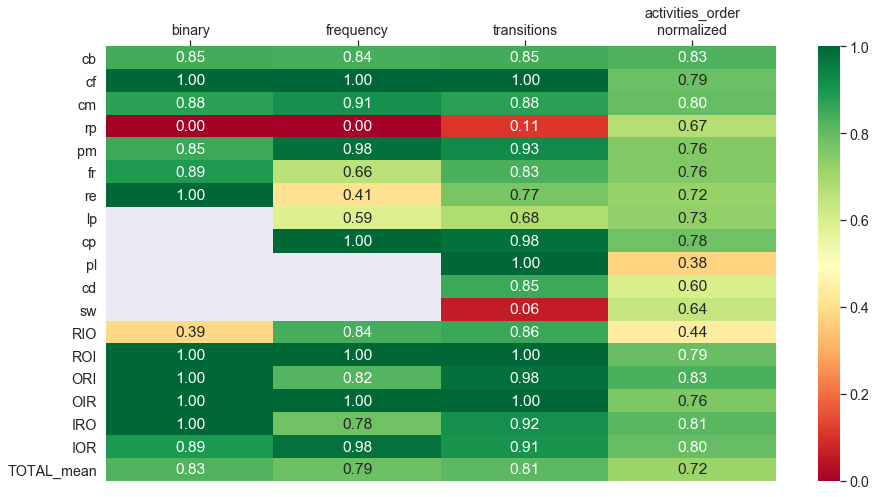

In [36]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(15,8))
ax = sns.heatmap(
    r[['binary', 'frequency', 'transitions', 'activities_order\nnormalized']]
    ,annot=True
    ,vmin=0
    ,vmax=1
    ,robust=True
    ,fmt='.2f'
    ,cmap="RdYlGn"
)
ax.xaxis.tick_top()
plt.yticks(rotation=0);

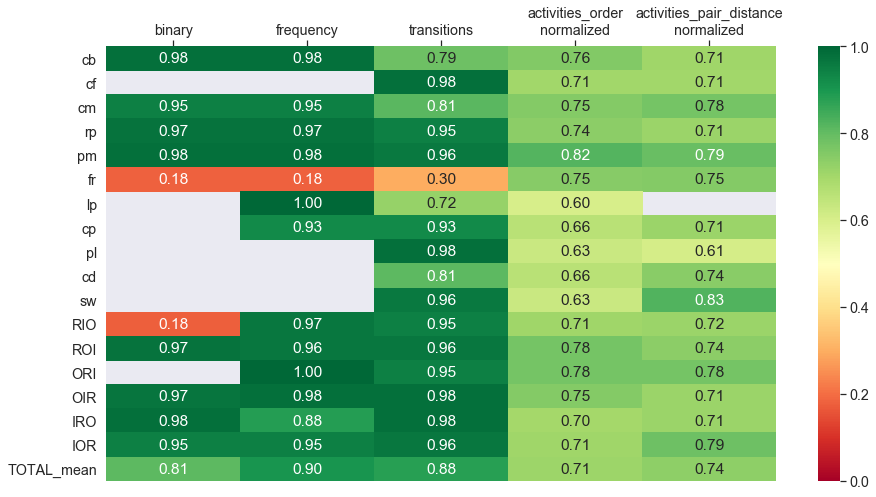

In [114]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(15,8))
ax = sns.heatmap(
    r
    ,annot=True
    ,vmin=0
    ,vmax=1
    ,robust=True
    ,fmt='.2f'
    ,cmap="RdYlGn"
)
ax.xaxis.tick_top()
plt.yticks(rotation=0);

### Best Results Individually

In [38]:
best_results_individually = results_log_size[results_log_size.detection_type == 'tradicional'].sort_values(
    'F1_mean', ascending=False
).drop_duplicates(subset=['representation', 'tipo_mudanca'])

In [41]:
indv = best_results_individually.groupby(['representation', 'tipo_mudanca'])['F1_mean'].mean().reset_index()
indv = indv.pivot_table(values='F1_mean', index='tipo_mudanca', columns='representation')
indv.columns = ['activities_order\nnormalized', 
        'binary', 'frequency', 'transitions']
indv.loc['TOTAL_mean'] = indv.mean()
indv = indv.loc[transitions_support + composite + ["TOTAL_mean"]][[
    'binary',
    'frequency',
    'transitions',
    'activities_order\nnormalized',
]]

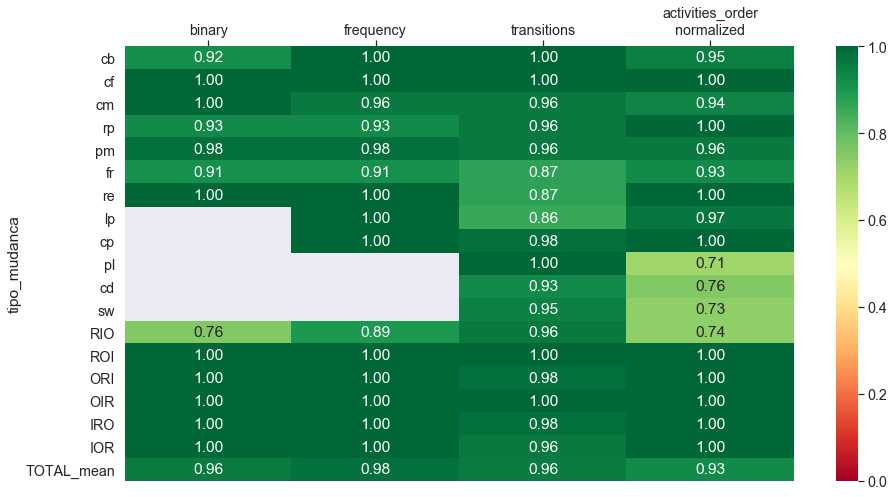

In [42]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(15,8))
ax = sns.heatmap(
    indv
    ,annot=True
    ,vmin=0
    ,vmax=1
    ,robust=True
    ,fmt='.2f'
    ,cmap="RdYlGn"
)
ax.xaxis.tick_top()
plt.yticks(rotation=0);

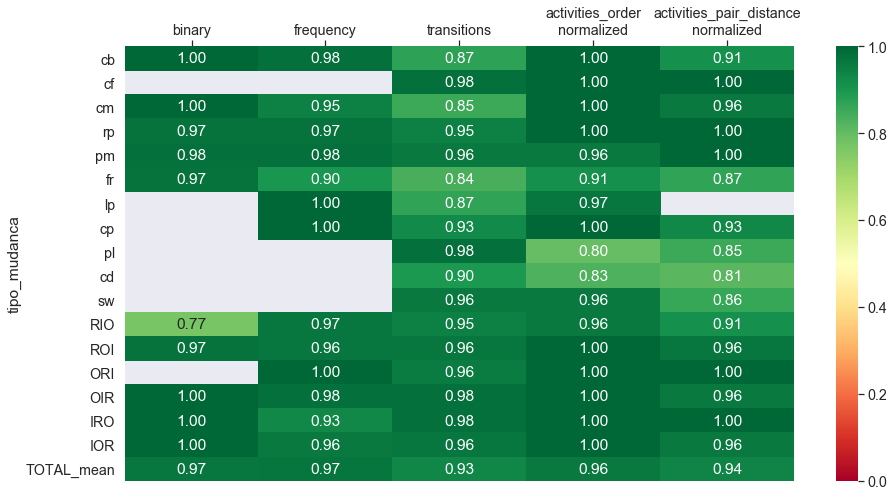

In [145]:
sns.set(font_scale=1.3)
plt.subplots(figsize=(15,8))
ax = sns.heatmap(
    indv
    ,annot=True
    ,vmin=0
    ,vmax=1
    ,robust=True
    ,fmt='.2f'
    ,cmap="RdYlGn"
)
ax.xaxis.tick_top()
plt.yticks(rotation=0);

In [146]:
gc.collect()

113599